/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

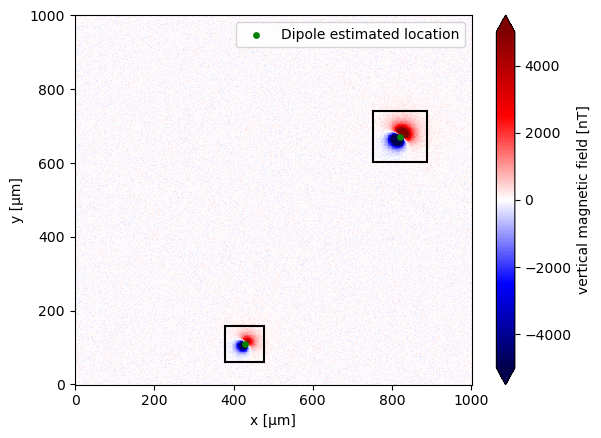

In [1]:
import ensaio
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import skimage.exposure
import xarray as xr

import magali as mg

SEED = 42
rng = np.random.default_rng(SEED)

sensor_sample_distance = 5.0
region = [0, 1000, 0, 1000]
spacing = 2.0
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5
size = 2

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=SEED,
)

dipoles_amplitude = abs(rng.normal(0, 100, size)) * 1.0e-14
dipole_coordinates = (
    rng.integers(30, 950, size),
    rng.integers(30, 950, size),
    rng.integers(-10, -1, size),
)

dipole_moments = hm.magnetic_angles_to_vec(
    inclination=directions_inclination,
    declination=directions_declination,
    intensity=dipoles_amplitude,
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
noise_std_dev = 100
data.values += rng.normal(loc=0, scale=noise_std_dev, size=data.shape)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.2,
    border_exclusion=2,
)

data_updated, euler_locations_, dipole_moments_, r2_values = (
    mg.iterative_nonlinear_inversion(
        data_up,
        bounding_boxes,
        height_difference=height_difference,
        copy_data=True,
    )
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(euler_locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()

In [2]:
dipole_coordinates

(array([428, 819]), array([109, 671]), array([ -9, -10]))

In [3]:
euler_locations_

[array([427.95875783, 109.01600238,  -8.74080318]),
 array([819.00354554, 670.99399332,   5.71432648])]

In [4]:
dipole_locations = []
for i in range(len(dipole_coordinates[0])):
    dipole_locations.append(
        np.array(
            [
                dipole_coordinates[0][i],
                dipole_coordinates[1][i],
                dipole_coordinates[2][i],
            ]
        )
    )
print(dipole_locations)

[array([428, 109,  -9]), array([819, 671, -10])]


In [5]:
distances = [np.linalg.norm(a - b) for a, b in zip(dipole_locations, euler_locations_)]
distances

[np.float64(0.2629448323568683), np.float64(15.71432802710971)]

In [6]:
import choclo
import harmonica as hm
import numba
import numpy as np
import verde as vd

from magali._synthetic import dipole_bz
from magali._units import (
    coordinates_micrometer_to_meter,
    meter_to_micrometer,
    tesla_to_nanotesla,
)
from magali._validation import check_fit_input


class MagneticMomentBz:
    def __init__(self, location):
        self.location = location
        self.dipole_moment_ = None

    def fit(self, coordinates, data):
        coordinates, data = check_fit_input(coordinates, data)
        jacobian = self.jacobian(coordinates)
        self.dipole_moment_ = np.linalg.solve(jacobian.T @ jacobian, jacobian.T @ data)
        return self

    def jacobian(self, coordinates):
        xc, yc, zc = coordinates_micrometer_to_meter(self.location)
        x, y, z = (c.ravel() for c in coordinates_micrometer_to_meter(coordinates))
        n_data = x.size
        n_params = 3
        jacobian = np.empty((n_data, n_params))
        jacobian_linear_jit(x, y, z, xc, yc, zc, jacobian)
        jacobian = tesla_to_nanotesla(jacobian)
        return jacobian


def _jacobian_linear(x, y, z, xc, yc, zc, result):
    factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
    n_data = x.size
    for i in numba.prange(n_data):
        r = choclo.utils.distance_cartesian(x[i], y[i], z[i], xc, yc, zc)
        kernel_eu = choclo.point.kernel_eu(x[i], y[i], z[i], xc, yc, zc, r)
        kernel_nu = choclo.point.kernel_nu(x[i], y[i], z[i], xc, yc, zc, r)
        kernel_uu = choclo.point.kernel_uu(x[i], y[i], z[i], xc, yc, zc, r)
        result[i, 0] = factor * kernel_eu
        result[i, 1] = factor * kernel_nu
        result[i, 2] = factor * kernel_uu


class NonlinearMagneticDipoleBz:
    def __init__(
        self,
        initial_location,
        max_iter=100,
        tol=1e-2,
        alpha_init=1,
        alpha_scale=10.0,
    ):
        self.initial_location = initial_location
        self.max_iter = max_iter
        self.tol = tol
        self.alpha_init = alpha_init
        self.alpha_scale = alpha_scale

    def predict(self, coordinates):
        if not hasattr(self, "location_") or not hasattr(self, "dipole_moment_"):
            msg = "Model has not been fitted yet. Call 'fit' before 'predict'."
            raise AttributeError(msg)
        return dipole_bz(coordinates, self.location_, self.dipole_moment_)

    def jacobian(self, coordinates, location, moment, jacobian):
        x, y, z = coordinates
        xc, yc, zc = coordinates_micrometer_to_meter(location)
        jacobian_nonlinear_jit(
            x,
            y,
            z,
            xc,
            yc,
            zc,
            moment[0],
            moment[1],
            moment[2],
            jacobian,
        )
        return jacobian

    def fit(self, coordinates, data):
        coordinates, data = check_fit_input(coordinates, data)
        coordinates_m = tuple(
            c.ravel() for c in coordinates_micrometer_to_meter(coordinates)
        )
        location = np.asarray(self.initial_location)
        linear_model = MagneticMomentBz(location)
        linear_model.fit(coordinates, data)
        moment = linear_model.dipole_moment_
        residual = data - dipole_bz(coordinates, location, moment)
        misfit = [np.linalg.norm(residual)]
        jacobian = np.empty((data.size, 3))
        identity = np.identity(3)
        for _ in range(self.max_iter):
            location_misfit = [misfit[-1]]
            for _ in range(self.max_iter):
                jacobian = self.jacobian(coordinates_m, location, moment, jacobian)
                hessian = jacobian.T @ jacobian
                # Make alpha proportional to the curvature scale
                scaling_factor = 1e-3
                alpha = scaling_factor * max(np.median(np.diag(hessian)), 1e-30)
                gradient = jacobian.T @ residual
                took_a_step = False
                for _ in range(50):
                    # build damping matrix proportional to diag(H)
                    diagH = np.diag(np.diag(hessian))
                    damping = alpha * diagH
                    # small floor to avoid zero diagonal
                    damping += 1e-20 * np.eye(3)
                    delta = np.linalg.solve(hessian + damping, gradient)
                    max_step_m = 1e-6  # 10 µm
                    step_norm = np.linalg.norm(delta)
                    if step_norm > max_step_m:
                        delta = delta * (max_step_m / step_norm)

                    trial_location = location + meter_to_micrometer(delta)
                    trial_predicted = dipole_bz(
                        coordinates,
                        trial_location,
                        moment,
                    )
                    trial_residual = data - trial_predicted
                    trial_misfit = np.linalg.norm(trial_residual)
                    if trial_misfit < location_misfit[-1]:
                        location = trial_location
                        residual = trial_residual
                        alpha /= self.alpha_scale
                        location_misfit.append(trial_misfit)
                        took_a_step = True
                        break
                    alpha *= self.alpha_scale
                if not took_a_step:
                    break
                if (
                    abs(location_misfit[-1] - location_misfit[-2]) / location_misfit[-2]
                    < self.tol
                ):
                    break
            linear_model = MagneticMomentBz(location).fit(coordinates, data)
            moment = linear_model.dipole_moment_
            residual = data - dipole_bz(coordinates, location, moment)
            misfit.append(np.linalg.norm(residual))
            if abs(misfit[-1] - misfit[-2]) / misfit[-2] < self.tol:
                break
        self.location_ = location
        self.dipole_moment_ = moment
        self.misfit_ = misfit

        # Calculate R²
        predicted_data = dipole_bz(coordinates, self.location_, self.dipole_moment_)
        residual_sum_squares = np.sum((data - predicted_data) ** 2)
        total_sum_squares = np.sum((data - np.mean(data)) ** 2)

        self.r2_ = 1 - residual_sum_squares / total_sum_squares
        return self


def _jacobian_nonlinear(x, y, z, xc, yc, zc, mx, my, mz, result):
    factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
    for i in numba.prange(x.size):
        dx = x[i] - xc
        dy = y[i] - yc
        dz = z[i] - zc
        r2 = dx**2 + dy**2 + dz**2
        # prevent huge derivatives if (xc,yc,zc) gets very near an observation
        if r2 < 1e-18:
            r2 = 1e-18
        r5 = r2 ** (5 / 2)
        r7 = r2 ** (7 / 2)
        r5 = r2 ** (5 / 2)
        r7 = r2 ** (7 / 2)
        # ∂bz / ∂xc
        dBz_dxc = factor * (
            (15 * my * dy * dz * dx) / r7
            + mz * ((15 * dz**2 * dx) / r7 - (3 * dx) / r5)
            + (15 * mx * dz * dx**2) / r7
            - (3 * mx * dz) / r5
        )
        # ∂bz / ∂yc
        dBz_dyc = factor * (
            (15 * mx * dx * dz * dy) / r7
            + mz * ((15 * dz**2 * dy) / r7 - (3 * dy) / r5)
            + (15 * my * dz * dy**2) / r7
            - (3 * my * dz) / r5
        )
        # ∂bz / ∂zc
        dBz_dzc = factor * (
            mz * ((15 * dz**3) / r7 - (9 * dz) / r5)
            + (15 * my * dy * dz**2) / r7
            - (3 * my * dy) / r5
            + (15 * mx * dx * dz**2) / r7
            - (3 * mx * dx) / r5
        )
        # Convert to nT
        result[i, 0] = dBz_dxc * 1e9
        result[i, 1] = dBz_dyc * 1e9
        result[i, 2] = dBz_dzc * 1e9


jacobian_linear_jit = numba.jit(_jacobian_linear, nopython=True, parallel=True)
jacobian_nonlinear_jit = numba.jit(_jacobian_nonlinear, nopython=True, parallel=True)

In [7]:
import choclo
import harmonica as hm
import numba
import numpy as np
import verde as vd


def iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=5.0,
    copy_data=True,
):
    locations_ = []
    dipole_moments_ = []
    r2_values = []

    table = vd.grid_to_table(data_up)
    global_coordinates = (table.x.values, table.y.values, table.z.values)

    data_updated = data_up.copy(deep=True) if copy_data else data_up

    for box in bounding_boxes:
        anomaly = data_updated.sel(x=slice(*box[:2]), y=slice(*box[2:]))

        dx, dy, dz, tga = mg.gradient(anomaly)
        anomaly["dx"], anomaly["dy"], anomaly["dz"], anomaly["tga"] = dx, dy, dz, tga

        table = vd.grid_to_table(anomaly)

        euler = hm.EulerDeconvolution(3)
        euler.fit((table.x, table.y, table.z), (table.bz, table.dx, table.dy, table.dz))

        bz_corrected = table.bz.values - euler.base_level_
        coordinates = (table.x.values, table.y.values, table.z.values)

        model_nl = NonlinearMagneticDipoleBz(
            initial_location=euler.location_, max_iter=1000
        )
        model_nl.fit(coordinates, bz_corrected)

        locations_.append(model_nl.location_)
        dipole_moments_.append(model_nl.dipole_moment_)
        r2_values.append(model_nl.r2_)

        modeled_bz = mg.dipole_bz(
            global_coordinates, model_nl.location_, model_nl.dipole_moment_
        )
        for x_val, y_val, bz_val in zip(table.x.values, table.y.values, modeled_bz):
            data_updated.loc[{"x": x_val, "y": y_val}] -= bz_val

        data_updated = (
            hm.upward_continuation(data_updated, height_difference)
            .assign_attrs(data_updated.attrs)
            .assign_coords(x=data_updated.x, y=data_updated.y)
            .assign_coords(z=data_updated.z + height_difference)
            .rename("bz")
        )
        dx, dy, dz, tga = mg.gradient(data_updated)
        data_updated["dx"] = dx
        data_updated["dy"] = dy
        data_updated["dz"] = dz
        data_updated["tga"] = tga

    return data_updated, locations_, dipole_moments_, r2_values

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

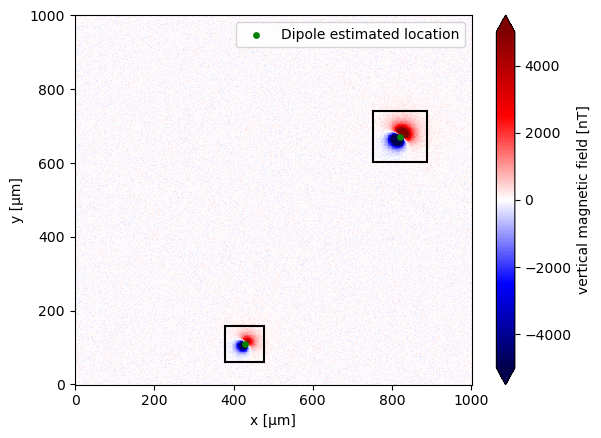

[np.float64(0.2629448323568683), np.float64(15.714328027105177)]


In [8]:
SEED = 42
rng = np.random.default_rng(SEED)

sensor_sample_distance = 5.0
region = [0, 1000, 0, 1000]
spacing = 2.0
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5
size = 2

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=SEED,
)

dipoles_amplitude = abs(rng.normal(0, 100, size)) * 1.0e-14
dipole_coordinates = (
    rng.integers(30, 950, size),
    rng.integers(30, 950, size),
    rng.integers(-10, -1, size),
)

dipole_moments = hm.magnetic_angles_to_vec(
    inclination=directions_inclination,
    declination=directions_declination,
    intensity=dipoles_amplitude,
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
noise_std_dev = 100
data.values += rng.normal(loc=0, scale=noise_std_dev, size=data.shape)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.2,
    border_exclusion=2,
)

data_updated, locations_, dipole_moments_, r2_values = iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()

distances = [np.linalg.norm(a - b) for a, b in zip(dipole_locations, locations_)]
print(distances)

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

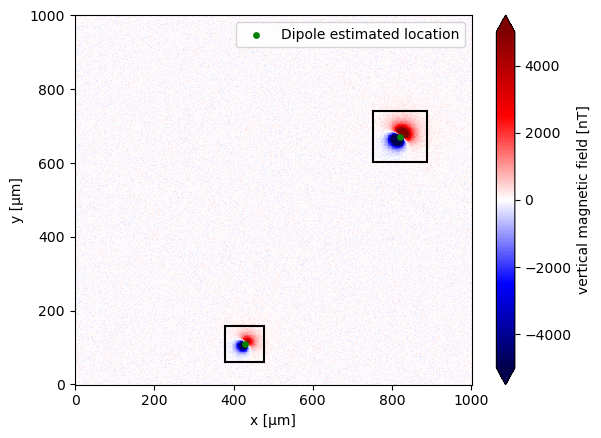

In [9]:
data_updated, locations_, dipole_moments_, r2_values = iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()

In [10]:
distances = [np.linalg.norm(a - b) for a, b in zip(dipole_locations, locations_)]
distances

[np.float64(0.2629448323568683), np.float64(15.714328027105177)]

In [11]:
locations_

[array([427.95875783, 109.01600238,  -8.74080318]),
 array([819.00354554, 670.99399332,   5.71432648])]

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

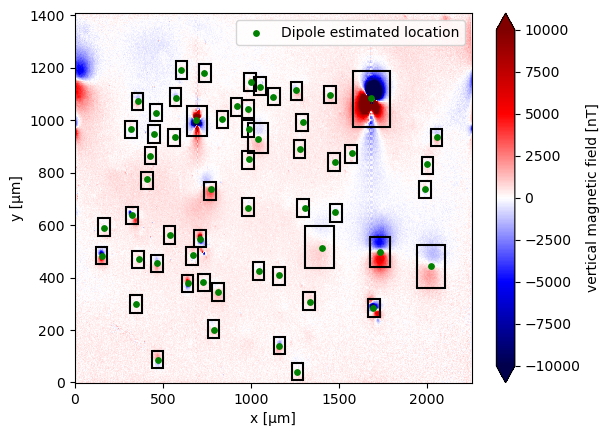

In [12]:
fname = ensaio.fetch_morroco_speleothem_qdm(version=1, file_format="matlab")
data = mg.read_qdm_harvard(fname)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.02,
    border_exclusion=2,
)

data_updated, locations_, dipole_moments_, r2_values = iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

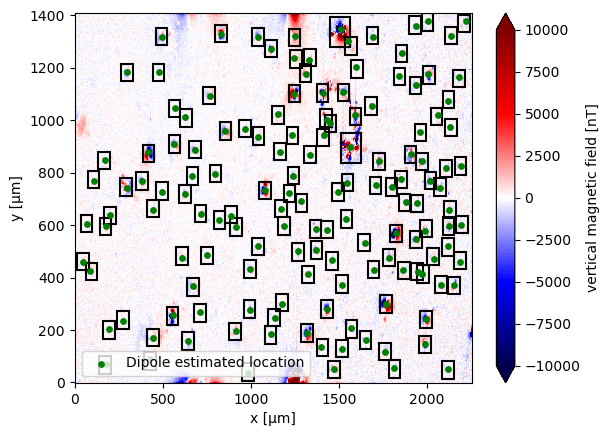

In [22]:
data = mg.read_qdm_harvard("NRM1.mat")

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.02,
    border_exclusion=2,
)

data_updated, locations_, dipole_moments_, r2_values = iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()